In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
import seaborn as sns
sns.set_style("white")
sns.set(context='notebook',
        style='ticks',
        font_scale=1,
        rc={'axes.grid':True,
            'grid.color':'.9',
            'grid.linewidth':0.75})

import contextlib
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
import itertools
from scipy.stats import fisher_exact

import warnings
warnings.simplefilter('ignore', DeprecationWarning)

In [2]:
# support functions
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [3]:
def mse(p, delta, n, m):
    q = p + delta
    nom = n*p*(1-p) + m*q*(1-q) + m**2*(p-q)**2
    denom = (n+m)**2
    return nom/denom

Text(0.5, 1.0, '$p = 0.5, q = p + \\Delta$')

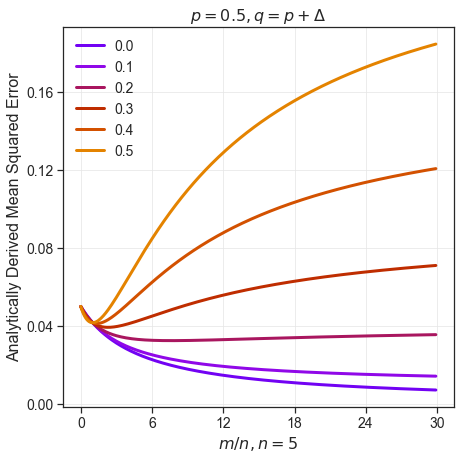

In [4]:
p = 0.5
delta_list = np.arange(0, 0.5+1e-3, 0.1)
n = 5
m_list = np.arange(0, 30, 0.1)

mse_list = []
for delta in delta_list:
    mse_delta = []
    for m in m_list:
        mse_delta.append(mse(p, delta, n, m))
    mse_list.append(mse_delta)
mse_list = np.array(mse_list)

fontsize = 16
labelsize = 14
fig, ax = plt.subplots(figsize=(7, 7))
cmap = [plt.cm.gnuplot(i) for i in np.linspace(0.2, 0.8, len(delta_list))]
for i, delta in enumerate(delta_list):
    ax.plot(m_list, mse_list[i], c=cmap[i], lw=3, label=str(np.round(delta, 2)))
ax.set_ylabel("Analytically Derived Mean Squared Error", fontsize=fontsize)
ax.set_xlabel(r"$m/n, n={}$".format(n), fontsize=fontsize)
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
ax.legend(fontsize=labelsize, frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.set_title(r"$p = {}, q = p + \Delta$".format(p), fontsize=fontsize)

In [20]:
def get_ideal_criterion(p, q, n, m):
    delta = q - p
    coeff = [m*(m-1)/(n+m)**2, m*(1-2*p)/(n+m)**2, -m*p*(1-p)/(n*(n+m))]
    thresh = np.roots(coeff)
    thresh = thresh[thresh > 0]
    if len(thresh) == 0:
        return 0
    else:
        return delta - thresh[0]
    
def get_hodges_estimator(p_hat, q_hat, p_comb, p, q, plugin=False):
    if m != 0:
        if plugin:
            criterion = get_ideal_criterion(p_hat, q_hat, n, m)
        else:
            criterion = get_ideal_criterion(p, q, n, m)
    else:
        criterion = 1
    
    if criterion > 0:
        p_hodges = p_hat
    else:
        p_hodges = p_comb
    return p_hodges

def compute_squared_error(p, q, n, m):
    p_hat = np.random.binomial(n, p, 1)[0] / n
    if m == 0:
        q_hat = 0
    else:
        q_hat = np.random.binomial(m, q, 1)[0] / m
    
    p_comb = (n * p_hat + m * q_hat)/(n + m)
    p_hodges = get_hodges_estimator(p_hat, q_hat, p_comb, p, q, plugin=False)
    p_hodges_plugin = get_hodges_estimator(p_hat, q_hat, p_comb, p, q, plugin=True)

    mse_comb = (p_comb - p)**2
    mse_hodges = (p_hodges - p)**2
    mse_hodges_plugin = (p_hodges_plugin - p)**2

    return mse_comb, mse_hodges, mse_hodges_plugin

In [21]:
p = 0.5
delta_list = np.arange(0, 0.5+1e-3, 0.1)
n = 5
m_list = np.arange(0, 30, 2)
reps = 10000

In [22]:
hodges_list = []
hodgesp_list = []
comb_list = []

for delta in delta_list: 
    q = p + delta
    hodges_mse_list = []
    hodgesp_mse_list = []
    comb_mse_list = []
    
    for m in m_list: 
        q = p + delta

        f = lambda : compute_squared_error(p, q, n, m)

        with tqdm_joblib(tqdm(desc="Compute Acc", total=reps)) as progress_bar:
            ses = np.array(Parallel(n_jobs=-1)(delayed(f)() for i in range(reps)))
        
        mses = np.mean(ses, axis=0)
        comb_mse_list.append(mses[0])
        hodges_mse_list.append(mses[1])
        hodgesp_mse_list.append(mses[2])
        
    hodges_list.append(hodges_mse_list)
    comb_list.append(comb_mse_list)
    hodgesp_list.append(hodgesp_mse_list)
    
hodges_list = np.array(hodges_list)   
hodgesp_list = np.array(hodgesp_list)
comb_list = np.array(comb_list)

Compute Acc: 100%|██████████| 10000/10000 [00:00<00:00, 37271.74it/s]


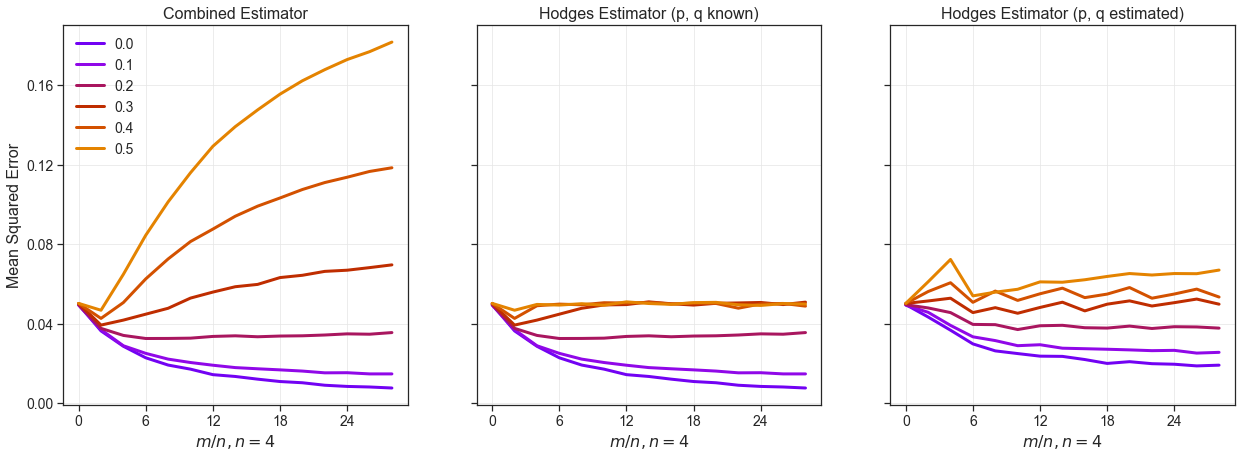

In [31]:
fontsize = 16
labelsize = 14
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
cmap = [plt.cm.gnuplot(i) for i in np.linspace(0.2, 0.8, len(delta_list))]
results = [comb_list, hodges_list, hodgesp_list]
titles = ["Combined Estimator", "Hodges Estimator (p, q known)", "Hodges Estimator (p, q estimated)"]
for j in range(3):
    ax = axes[j]
    for i, delta in enumerate(delta_list):
        ax.plot(m_list, results[j][i], c=cmap[i], lw=3, label=str(np.round(delta, 2)))
    ax.set_ylabel("Mean Squared Error", fontsize=fontsize)
    ax.set_xlabel(r"$m/n, n=4$", fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
    ax.legend(fontsize=labelsize, frameon=False)
    ax.xaxis.set_major_locator(MaxNLocator(6))
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.set_title(titles[j], fontsize=fontsize)

    if j == 0:
        ylim = ax.get_ylim()
    else:
        ax.set_ylim(*ylim)
        ax.set_ylabel("")
        ax.set_yticklabels("")
        ax.get_legend().remove()
